## Librerias

In [2]:
import pandas as pd
import numpy as np
import re # expresiones regulares (regex)
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler

# Preprocesamiento

* Eliminamos stopwords
* lematizamos
* Normalizamos el texto (quitamos mayúsculas y signos de puntuación)
* Vectorizamos y hacemos n-gramas
* Usamos SVD para ver cuantos topicos pueden tener los documentos

In [3]:
# Archivo npr.csv es para hacer pruebas

df = pd.read_csv('noticias-economicas-sample.csv')

textoPrueba = df[['text']].copy() # Pongo .copy() porque cuando intentas 
                                  # quitar las stopwords sale un warning.
textoPrueba = textoPrueba.head(1000)

print(textoPrueba.shape)
textoPrueba.head(10)

(1000, 1)


,text
0,Angela Merkel ayer en Berlin tras la cumbre te...
1,\r\n\r\n\r\n\r\n\r\nEnrique Quemada Clariana\r...
2,¿Cuántas veces no ha querido ser su propio jef...
3,"El ministro de Sanidad, Salvador Illa, momento..."
4,El Pleno del Congreso ha aprobado el proyecto ...
5,Vacunarse de la gripe para aliviar los hospita...
6,"Elon Musk, fundador de Tesla. EFE\r\n\r\nLa co..."
7,Una usuaria consulta la aplicación de banca ar...
8,Las consecuencias socioeconómicas de la pandem...
9,La aerolínea Ryanair anunció este viernes que ...


Eliminamos stopwords

In [4]:
# Función para eliminar stopwords en español

def noStopwords(text):
    
    sw_es = set(stopwords.words('spanish'))

    text = ' '.join([word for word in text.split() if word.lower() not in sw_es])
    
    return text


In [5]:
textoPrueba['text'] = textoPrueba['text'].apply(noStopwords)
textoPrueba.head()

,text
0,Angela Merkel ayer Berlin tras cumbre telemáti...
1,Enrique Quemada Clariana Fusiones adquisicione...
2,¿Cuántas veces querido ser propio jefe? ¿Cuánt...
3,"ministro Sanidad, Salvador Illa, momentos rued..."
4,Pleno Congreso aprobado proyecto Presupuestos ...


Aplicamos lematización

In [6]:
# Función para lematizar al texto
def lemmatize_text(text):

    # Cargamos el módulo de español
    nlp = spacy.load("es_core_news_sm")

    # nlp crea una pipeline que le adhiere metadata que la paquetería spacy usa
    doc = nlp(text)

    lemmatized_text = " ".join([token.lemma_ for token in doc])
    
    return lemmatized_text

In [7]:
textoPrueba['text'] = textoPrueba['text'].apply(lemmatize_text)
textoPrueba.head()

,text
0,Angela Merkel ayer Berlin tras cumbre telemáti...
1,Enrique Quemada Clariana Fusiones adquisición ...
2,¿ cuántar vez querido ser propio jefe ? ¿ cuán...
3,"ministro Sanidad , Salvador Illa , momento rod..."
4,Pleno Congreso aprobado proyecto Presupuestos ...


Normalizamos el texto, quitamos mayúsculas y signos de puntuación

In [8]:
# Función para normalizar el texto

def noPuntuacion(text):

    text = text.lower()

    text = re.sub('[áäàâ]', 'a', text)
    text = re.sub('[éëèê]', 'e', text)
    text = re.sub('[íïìî]', 'i', text)
    text = re.sub('[óöòô]', 'o', text)
    text = re.sub('[úüùû]', 'u', text)

    return re.findall(r'[a-zñ]+', text)

In [40]:
textoPrueba['text'] = textoPrueba['text'].apply(noPuntuacion).apply(lambda x: " ".join(x))
textoPrueba.head()

,text
0,angela merkel ayer berlin tras cumbre telemati...
1,enrique quemada clariana fusiones adquisicion ...
2,cuantar vez querido ser propio jefe cuantar ve...
3,ministro sanidad salvador illa momento rodar p...
4,pleno congreso aprobado proyecto presupuestos ...


Aplicamos stemming (Optamos por no ponerla)

In [10]:
# # Función para aplicar stemming al texto

# def stemmiar(text):

#     stemmer = SnowballStemmer('spanish')

#     return ' '.join([stemmer.stem(word) for word in text.split()])

In [11]:
# textoPrueba['text'] = textoPrueba['text'].apply(stemmiar)
# textoPrueba.head()

Vectorizamos y hacemos n-gramas

In [12]:
# Creamos una instancia que hará la vectorización TF-IDF
vect = TfidfVectorizer()

# Tokenizamos como Penn Treebank
tokenizer = TreebankWordTokenizer()
vect.set_params(tokenizer=tokenizer.tokenize)

# Incluimos 1-grams y 2-grams
vect.set_params(ngram_range=(1, 2))

# Ignoramos términos que aparecen en más del 70% de los documentos
vect.set_params(max_df=0.7)

# Solo mantenemos los términos que aparecen en al menos 2 documentos
vect.set_params(min_df=2)

TfidfVectorizer(max_df=0.7, min_df=2, ngram_range=(1, 2),
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x00000185AC68F250>>)

In [13]:
# Lo aplicamos
vectFit = vect.fit_transform(textoPrueba['text']) 
vectFit 

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<1000x36966 sparse matrix of type '<class 'numpy.float64'>'
	with 260826 stored elements in Compressed Sparse Row format>

In [14]:
print(vectFit[1])

  (0, 35090)	0.060396578129908285
  (0, 14512)	0.04501305740183989
  (0, 26566)	0.05784523463169655
  (0, 30655)	0.052882213857139995
  (0, 35260)	0.060396578129908285
  (0, 29916)	0.05784523463169655
  (0, 14250)	0.060396578129908285
  (0, 9017)	0.03258906578368043
  (0, 21466)	0.05784523463169655
  (0, 28649)	0.052882213857139995
  (0, 12345)	0.060396578129908285
  (0, 26326)	0.060396578129908285
  (0, 7231)	0.05424931793620323
  (0, 6556)	0.05784523463169655
  (0, 35678)	0.05784523463169655
  (0, 13639)	0.060396578129908285
  (0, 11481)	0.05784523463169655
  (0, 645)	0.04159276271841367
  (0, 2354)	0.060396578129908285
  (0, 36824)	0.05784523463169655
  (0, 25616)	0.05424931793620323
  (0, 11345)	0.060396578129908285
  (0, 2839)	0.060396578129908285
  (0, 34555)	0.060396578129908285
  (0, 4969)	0.060396578129908285
  :	:
  (0, 2811)	0.04501305740183989
  (0, 534)	0.03526988051264151
  (0, 808)	0.038608717706793506
  (0, 12668)	0.08466448534575763
  (0, 22650)	0.048873728737012956
  

Descomposicion por valores singulares (SVD)

Hacemos z-score normalizacion

In [15]:
# Creamos la instancia 
scaler = StandardScaler(with_mean=False)
# Calculamos el promedio y la desviacion estandar
scaler.fit(vectFit)
# Re escalamos
vectFitScaled = scaler.transform(vectFit)

print(vectFitScaled[0])

  (0, 31257)	9.254913690852511
  (0, 25175)	20.13417179718722
  (0, 3528)	1.921999740323618
  (0, 21428)	12.22845930089941
  (0, 25728)	30.745086348767074
  (0, 22028)	2.743491885110464
  (0, 34935)	10.063636290795838
  (0, 3360)	3.2772372305307944
  (0, 25571)	10.51418608784329
  (0, 22240)	6.40481295829969
  (0, 31744)	12.682812919895763
  (0, 31221)	2.9832096892356965
  (0, 35647)	4.590984685925436
  (0, 11109)	20.405318035635442
  (0, 1943)	24.926888969312905
  (0, 34922)	7.287421668336652
  (0, 15431)	17.21319349717695
  (0, 4113)	11.828947686617525
  (0, 18620)	21.84280830610786
  (0, 13871)	24.815996578731177
  (0, 13444)	25.250190413761796
  (0, 14542)	18.95621039927713
  (0, 11600)	26.66849358972337
  (0, 7748)	4.447513614552788
  (0, 15836)	8.8050759490576
  :	:
  (0, 18568)	8.303021898731256
  (0, 16570)	1.4953130268855748
  (0, 7839)	2.440737120753125
  (0, 18053)	5.572660759192016
  (0, 24134)	4.991659448695931
  (0, 9024)	2.697328246256344
  (0, 7223)	2.881776403642657
  

In [16]:
# vectFitScaled = vectFitScaled.transpose()
# vectFitScaled

In [17]:
# Creamos instancia de la clase TruncatedSVD
dimReduction = TruncatedSVD(n_components = 1000, random_state = 2)

In [18]:
# Ajustamos la transfromacion con nuestros datos
dimReduction.fit(vectFitScaled)

TruncatedSVD(n_components=1000, random_state=2)

In [19]:
# Reducimos la dimensionalidad
dataReduction = dimReduction.transform(vectFitScaled)

In [20]:
print("Variancia explicada por los 36,755 componentes = " \
        + str(sum(dimReduction.explained_variance_ratio_ * 100)))

Variancia explicada por los 36,755 componentes = 100.00000000000004


In [21]:
dimReduction.explained_variance_ratio_ * 100

array([3.01237998e+00, 1.05683500e+00, 8.56319203e-01, 8.64762107e-01,
       8.25034628e-01, 3.05753988e-01, 6.05778202e-01, 5.80375098e-01,
       5.41324796e-01, 5.01103525e-01, 4.65842576e-01, 3.04838910e-01,
       2.81036470e-01, 2.45665887e-01, 2.41409380e-01, 2.39358205e-01,
       2.35619644e-01, 2.32753591e-01, 2.30074255e-01, 2.26772648e-01,
       2.19259321e-01, 2.15724138e-01, 2.13841373e-01, 2.11152180e-01,
       2.10849639e-01, 2.09059611e-01, 2.05877526e-01, 2.04590468e-01,
       2.01614889e-01, 1.98218884e-01, 1.97474948e-01, 1.96136586e-01,
       1.93955863e-01, 1.91822166e-01, 1.91246243e-01, 1.89330439e-01,
       1.88567013e-01, 1.87674161e-01, 1.87227757e-01, 1.85843855e-01,
       1.84225941e-01, 1.83697790e-01, 1.82684042e-01, 1.81799095e-01,
       1.80735066e-01, 1.79262942e-01, 1.78605344e-01, 1.77692533e-01,
       1.76873932e-01, 1.75749886e-01, 1.75548614e-01, 1.74870693e-01,
       1.73959453e-01, 1.73289554e-01, 1.72433092e-01, 1.71034811e-01,
      

In [22]:
np.cumsum(dimReduction.explained_variance_ratio_ * 100)

array([  3.01237998,   4.06921498,   4.92553419,   5.79029629,
         6.61533092,   6.92108491,   7.52686311,   8.10723821,
         8.64856301,   9.14966653,   9.61550911,   9.92034802,
        10.20138449,  10.44705037,  10.68845975,  10.92781796,
        11.1634376 ,  11.39619119,  11.62626545,  11.8530381 ,
        12.07229742,  12.28802156,  12.50186293,  12.71301511,
        12.92386475,  13.13292436,  13.33880189,  13.54339235,
        13.74500724,  13.94322613,  14.14070107,  14.33683766,
        14.53079352,  14.72261569,  14.91386193,  15.10319237,
        15.29175938,  15.47943355,  15.6666613 ,  15.85250516,
        16.0367311 ,  16.22042889,  16.40311293,  16.58491203,
        16.76564709,  16.94491003,  17.12351538,  17.30120791,
        17.47808184,  17.65383173,  17.82938034,  18.00425104,
        18.17821049,  18.35150004,  18.52393314,  18.69496795,
        18.86568273,  19.03577772,  19.20509859,  19.37393192,
        19.54223618,  19.71026462,  19.87744882,  20.04

Text(0, 0.5, 'Variancia explicada (%)')

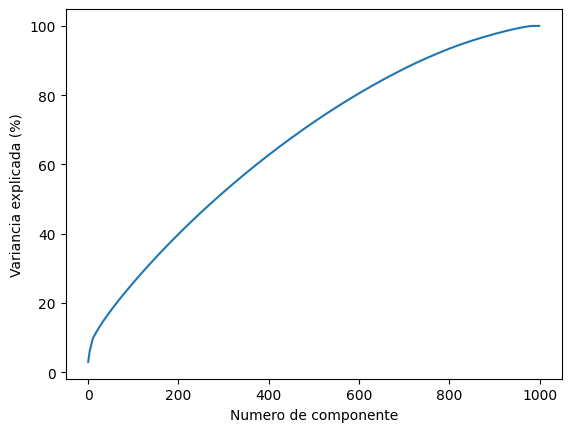

In [23]:
plt.plot(np.cumsum(dimReduction.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componente")
plt.ylabel("Variancia explicada (%)")

In [24]:
# Creamos instancia de la clase TruncatedSVD
dimReduction2 = TruncatedSVD(n_components = 2, random_state = 2)

# Ajustamos la transfromacion con nuestros datos
dimReduction2.fit(vectFitScaled)

# Reducimos la dimensionalidad
dataReduction2 = dimReduction2.transform(vectFitScaled)

print("Variancia explicada por 2 componentes = " \
        + str(sum(dimReduction2.explained_variance_ratio_ * 100)))

Variancia explicada por 2 componentes = 4.069166321415231


Text(0, 0.5, 'Segundo componente')

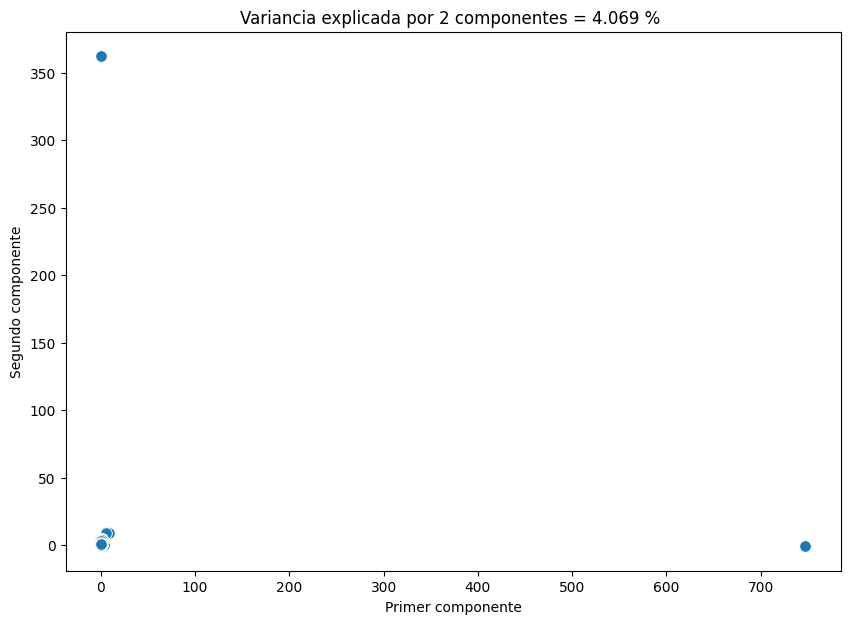

In [25]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=dataReduction2[:,0], y=dataReduction2[:,1], s=70)
plt.title(f"Variancia explicada por 2 componentes = {round(sum(dimReduction2.explained_variance_ratio_ * 100),3)} % ")
plt.xlabel("Primer componente")
plt.ylabel("Segundo componente")

Estandarizamos la matriz para meterla al LDA

In [26]:
scaler = MaxAbsScaler()
scaler.fit(vectFit)
vectFitStandardized = scaler.transform(vectFit)

In [27]:
print(vectFitStandardized[1])

  (0, 35090)	1.0
  (0, 14512)	0.9362427513109797
  (0, 26566)	1.0
  (0, 30655)	0.1509002418998035
  (0, 35260)	1.0
  (0, 29916)	1.0
  (0, 14250)	0.17675582454257108
  (0, 9017)	0.28517217590782434
  (0, 21466)	1.0
  (0, 28649)	0.37990288793596116
  (0, 12345)	0.7956730632305906
  (0, 26326)	1.0
  (0, 7231)	0.7966353200343786
  (0, 6556)	1.0
  (0, 35678)	0.9790780323013342
  (0, 13639)	0.3740788270343755
  (0, 11481)	1.0
  (0, 645)	0.5154804858496752
  (0, 2354)	1.0
  (0, 36824)	1.0
  (0, 25616)	0.3880963272765422
  (0, 11345)	0.9304457231744585
  (0, 2839)	1.0
  (0, 34555)	1.0
  (0, 4969)	0.7819055969136574
  :	:
  (0, 2811)	0.2817825483168083
  (0, 534)	0.3184262981122551
  (0, 808)	0.16606032745740706
  (0, 12668)	0.3073483249249431
  (0, 22650)	0.3506526380513422
  (0, 25121)	0.15009703727596302
  (0, 12199)	0.167687441516377
  (0, 3347)	0.07381891773451725
  (0, 31616)	0.20947516086171122
  (0, 35638)	0.09865113269958233
  (0, 28267)	0.10444930583564965
  (0, 20899)	0.2987761020557

Obtención de palabras clave usando TF-IDF

In [32]:
# Obtener el vocabulario de términos
feature_names = vect.get_feature_names_out()

# Obtener las frecuencias de términos en el primer documento
doc_freqs = vectFit[0].toarray()[0]

# Crear una lista de tuplas que contienen el término y su frecuencia en el primer documento
doc_term_freqs = [(feature_names[i], doc_freqs[i]) for i in range(len(feature_names))]

# Ordenar la lista de tuplas por la frecuencia descendente
doc_term_freqs_sorted = sorted(doc_term_freqs, key=lambda x: x[1], reverse=True)

# Obtener las 10 palabras clave más importantes para el primer documento
doc_keywords = [term for term, freq in doc_term_freqs_sorted[:10]]

print(doc_keywords)


['confianza empresarial', 'situacion actual', 'empresarial', 'trimestre', 'confianza', 'destatis', 'ifo', 'pesimista', 'tercer trimestre', 'expectativa']


In [41]:
# Importar las bibliotecas necesarias
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer

# Tokenizar los documentos utilizando el tokenizador de Penn Treebank
tokenizer = TreebankWordTokenizer()
documentos = []
for documento in textoPrueba['text'].tolist():
    tokens = tokenizer.tokenize(documento)
    documentos.append(tokens)

# Crear un diccionario de términos a partir de los documentos
dictionary = corpora.Dictionary(documentos)

# Crear una representación de la bolsa de palabras de los documentos
corpus = [dictionary.doc2bow(documento) for documento in documentos]

# Entrenar un modelo LDA con 10 tópicos
model_lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

# Imprimir los tópicos
for idx, topic in model_lda.print_topics(num_topics=3):
    print('Tópico: {} \nPalabras clave: {}\n'.format(idx+1, topic))


Tópico: 10 
Palabras clave: 0.008*"el" + 0.006*"poder" + 0.006*"millon" + 0.005*"hacer" + 0.005*"ser" + 0.004*"año" + 0.004*"nuevo" + 0.004*"euros" + 0.003*"primero" + 0.003*"si"

Tópico: 1 
Palabras clave: 0.008*"el" + 0.007*"poder" + 0.004*"nuevo" + 0.004*"ser" + 0.004*"año" + 0.003*"hacer" + 0.003*"primero" + 0.003*"ir" + 0.003*"ver" + 0.003*"millon"

Tópico: 9 
Palabras clave: 0.013*"el" + 0.007*"año" + 0.005*"poder" + 0.005*"ser" + 0.004*"euros" + 0.004*"hacer" + 0.004*"millon" + 0.003*"nuevo" + 0.003*"si" + 0.003*"primero"

